Étape 1 : Détection du visage + extraction des yeux (Dlib)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

BASE_PATH = "/content/drive/MyDrive/fatigue_detection_data"  # adapte si besoin

def build_dataset(class_name):
    folder = os.path.join(BASE_PATH, class_name)
    paths = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith((".jpg", ".png"))]

    data = []
    for p in paths:
        filename = os.path.basename(p)
        video_id = filename[:2]  # ⬅️ les 3 premiers caractères
        data.append([p, video_id, class_name])

    return pd.DataFrame(data, columns=["path", "video_id", "label"])


# 1) Construire les deux datasets
df_drowsy = build_dataset("Drowsy_extracted")
df_non = build_dataset("Non_Drowsy_extracted")

# 2) Séparer train/test pour chaque classe
train_d, test_d = train_test_split(df_drowsy, test_size=0.2, random_state=42)
train_n, test_n = train_test_split(df_non, test_size=0.2, random_state=42)

# 3) Concaténer
train_df = pd.concat([train_d, train_n]).reset_index(drop=True)
test_df  = pd.concat([test_d, test_n]).reset_index(drop=True)

# 4) Séparer features / labels
X_train = train_df[["path", "video_id"]]
y_train = train_df["label"]

X_test = test_df[["path", "video_id"]]
y_test = test_df["label"]

train_df.head(), test_df.head()


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np

class EyeDataset(Dataset):
    def __init__(self, df, transform=None, img_size=(64,64)):
        self.df = df
        self.transform = transform
        self.classes = {"Drowsy_extracted": 1, "Non_Drowsy_extracted": 0}
        self.img_size = img_size  # taille fixe

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]["path"]
        label = self.classes[self.df.iloc[idx]["label"]]

        # Lire image en grayscale
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise FileNotFoundError(f"Image not found: {img_path}")

        # Resize à taille fixe
        img = cv2.resize(img, self.img_size)

        # Normalisation [0,1]
        img = img.astype("float32") / 255.0

        # Ajouter dimension canal : (1,H,W)
        img = np.expand_dims(img, axis=0)

        # Transformation optionnelle
        if self.transform:
            img = self.transform(torch.tensor(img))

        return torch.tensor(img, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# Construction du dataset
train_dataset = EyeDataset(train_df, img_size=(64,64))
test_dataset  = EyeDataset(test_df, img_size=(64,64))

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

len(train_dataset), len(test_dataset)



In [ ]:
# Apprentissage trop long on essaye de réduire le dataset
# Loss + Optimizer
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
from torch.utils.data import Subset

# Limiter à 100 images pour debug
train_subset = Subset(train_dataset, range(100))
test_subset  = Subset(test_dataset, range(100))

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_subset, batch_size=32, shuffle=False)

len(train_subset), len(test_subset)


# Pipeline

---



In [ ]:
# ========================================
# PIPELINE COMPLET - FATIGUE DETECTION
# ========================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# ========================================
# 1. DATASET ( Pas nécessaire si execution d'avant faite )
# ========================================

class EyeClassificationDataset(Dataset):
    """Dataset pour la classification open/closed."""
    def __init__(self, df, img_size=(64, 64)):
        self.df = df.reset_index(drop=True)
        self.img_size = img_size
        self.classes = {"Drowsy_extracted": 1, "Non_Drowsy_extracted": 0}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]["path"]
        label = self.classes[self.df.iloc[idx]["label"]]

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise FileNotFoundError(f"Image not found: {img_path}")

        img = cv2.resize(img, self.img_size)
        img = img.astype("float32") / 255.0
        img = np.expand_dims(img, axis=0)

        return torch.tensor(img, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


# ========================================
# 2. SEGMENTATION NETWORK (U-Net)
# ========================================

class UNetSegmentation(nn.Module):
    def __init__(self):
        super().__init__()

        # Contracting path
        self.down1 = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1), nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2)

        self.down2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2)

        self.down3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU()
        )

        # Expansive path
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.upconv1 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU()
        )

        self.up2 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.upconv2 = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU()
        )

        self.up3 = nn.ConvTranspose2d(32, 16, 2, stride=2)
        self.upconv3 = nn.Sequential(
            nn.Conv2d(32, 16, 3, padding=1), nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1), nn.ReLU()
        )

        self.out_conv = nn.Conv2d(16, 1, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        d1 = self.down1(x)
        p1 = self.pool1(d1)
        d2 = self.down2(p1)
        p2 = self.pool2(d2)
        d3 = self.down3(p2)
        p3 = self.pool3(d3)

        b = self.bottleneck(p3)

        u1 = self.up1(b)
        u1 = torch.cat([u1, d3], dim=1)
        u1 = self.upconv1(u1)

        u2 = self.up2(u1)
        u2 = torch.cat([u2, d2], dim=1)
        u2 = self.upconv2(u2)

        u3 = self.up3(u2)
        u3 = torch.cat([u3, d1], dim=1)
        u3 = self.upconv3(u3)

        return self.sigmoid(self.out_conv(u3))


# ========================================
# 3. DECISION NETWORK
# ========================================

class DecisionNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.image_branch = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU()
        )

        self.seg_branch = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU()
        )

        self.fusion = nn.Sequential(
            nn.Linear(384, 256), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(256, 128), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(128, 2)
        )

    def forward(self, image, seg_map, bottleneck_features):
        img_feat = self.image_branch(image)
        img_feat = torch.max(img_feat.view(img_feat.size(0), img_feat.size(1), -1), dim=2)[0]

        seg_feat = self.seg_branch(seg_map)
        seg_feat = torch.max(seg_feat.view(seg_feat.size(0), seg_feat.size(1), -1), dim=2)[0]

        combined = torch.cat([img_feat, seg_feat, bottleneck_features], dim=1)
        return self.fusion(combined)


# ========================================
# 4. MODÈLE COMPLET
# ========================================

class CompleteFatigueDetectionModel(nn.Module):
    def __init__(self, seg_model, freeze_seg=True):
        super().__init__()
        self.seg_model = seg_model
        self.decision_model = DecisionNetwork()

        if freeze_seg:
            for param in self.seg_model.parameters():
                param.requires_grad = False

    def forward(self, image):
        seg_map = self.seg_model(image)

        # Extract bottleneck features
        d1 = self.seg_model.down1(image)
        p1 = self.seg_model.pool1(d1)
        d2 = self.seg_model.down2(p1)
        p2 = self.seg_model.pool2(d2)
        d3 = self.seg_model.down3(p2)
        p3 = self.seg_model.pool3(d3)
        bottleneck = self.seg_model.bottleneck(p3)
        bottleneck_features = torch.max(
            bottleneck.view(bottleneck.size(0), bottleneck.size(1), -1), dim=2
        )[0]

        return self.decision_model(image, seg_map, bottleneck_features)


# ========================================
# 5. ENTRAÎNEMENT
# ========================================

def train_model(model, train_loader, val_loader, device, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

    best_acc = 0.0

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)

        train_acc = train_correct / train_total

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"  Train: Loss={train_loss/len(train_loader):.4f}, Acc={train_acc*100:.2f}%")
        print(f"  Val: Acc={val_acc*100:.2f}%")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_fatigue_model.pth")
            print("  ✓ Meilleur modèle sauvegardé!")

    print(f"\n✓ Entraînement terminé! Meilleure accuracy: {best_acc*100:.2f}%")


# ========================================
# 6. UTILISATION
# ========================================

if __name__ == "__main__":
    # Configuration
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Device: {device}")

    # Créer les datasets (utilise ton code existant)
    # train_dataset = EyeClassificationDataset(train_df)
    # val_dataset = EyeClassificationDataset(test_df)
    # train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    # val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Initialiser le modèle
    seg_model = UNetSegmentation().to(device)

    # Option 2: Utiliser un U-Net random (sous-optimal mais possible)
    # et l'entraîner end-to-end avec le Decision Network

    complete_model = CompleteFatigueDetectionModel(
        seg_model,
        freeze_seg=False  # Mettre True si U-Net déjà entraîné
    ).to(device)

    print("✓ Modèle créé!")
    print(f"  Paramètres totaux: {sum(p.numel() for p in complete_model.parameters()):,}")
    print(f"  Paramètres entraînables: {sum(p.numel() for p in complete_model.parameters() if p.requires_grad):,}")

    # Entraîner
    train_model(complete_model, train_loader, test_loader, device, num_epochs=10)

Device: cuda
✓ Modèle créé!
  Paramètres totaux: 1,176,787
  Paramètres entraînables: 1,176,787


FileNotFoundError: Image not found: /content/drive/MyDrive/fatigue_detection_data/Drowsy_extracted/V0496_face0_gauche.jpg

In [ ]:
# ========================================
# SAUVEGARDER LE MODÈLE APRÈS ENTRAÎNEMENT
# Version simplifiée - juste pour recharger et prédire
# ========================================

import torch
import os
from datetime import datetime

# Dossier de sauvegarde sur Google Drive
SAVE_DIR = "/content/fatigue_detection_models"
os.makedirs(SAVE_DIR, exist_ok=True)

print("\n" + "="*70)
print("💾 SAUVEGARDE DU MODÈLE FINAL")
print("="*70)

# ========================================
# OPTION 1: Sauvegarde complète (RECOMMANDÉ)
# ========================================

# Timestamp pour version unique
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Sauvegarde avec informations
checkpoint = {
    'model_state_dict': complete_model.state_dict(),
    'timestamp': timestamp,
    'architecture': 'CompleteFatigueDetectionModel',
    'input_size': (64, 64),
    'num_classes': 2
}

# Sauvegarde principale
main_path = os.path.join(SAVE_DIR, f"fatigue_model_{timestamp}.pth")
torch.save(checkpoint, main_path)
print(f"✓ Modèle complet: {main_path}")

# Sauvegarde "latest" (écrase l'ancien)
latest_path = os.path.join(SAVE_DIR, "fatigue_model_LATEST.pth")
torch.save(checkpoint, latest_path)
print(f"✓ Dernière version: {latest_path}")

# ========================================
# OPTION 2: Juste les poids (plus léger)
# ========================================

weights_path = os.path.join(SAVE_DIR, f"fatigue_weights_{timestamp}.pth")
torch.save(complete_model.state_dict(), weights_path)
print(f"✓ Poids uniquement: {weights_path}")

print("="*70)
print("✅ SAUVEGARDE TERMINÉE!")
print(f"📁 Emplacement: {SAVE_DIR}")

# Afficher la taille des fichiers
try:
    size_mb = os.path.getsize(main_path) / (1024 * 1024)
    print(f"📦 Taille du modèle: {size_mb:.2f} MB")
except:
    pass

print("="*70)
print("\n🎉 Modèle sauvegardé! Tu peux fermer le notebook.")
print("📌 Pour recharger: utilise 'fatigue_model_LATEST.pth'")

In [ ]:
# ========================================
# PRÉPARER UN DOSSIER DE TEST
# Pour tester le PERCLOS sur un échantillon
# ========================================

import os
import shutil
import random
from collections import defaultdict

BASE_PATH = "/content/drive/MyDrive/fatigue_detection_data"
TEST_OUTPUT_DIR = "/content/drive/MyDrive/fatigue_detection_data/test_sample"

# ========================================
# OPTION 1: Copier un échantillon aléatoire
# ========================================

def create_random_test_sample(drowsy_dir, non_drowsy_dir, output_dir,
                               num_videos=5, frames_per_video=50):
    """
    Crée un échantillon de test en sélectionnant des images aléatoires.

    Args:
        drowsy_dir: Dossier avec images Drowsy
        non_drowsy_dir: Dossier avec images Non-Drowsy
        output_dir: Dossier de sortie
        num_videos: Nombre de vidéos à échantillonner
        frames_per_video: Nombre d'images par vidéo
    """

    os.makedirs(output_dir, exist_ok=True)

    print(f"📁 Création d'un échantillon de test...")
    print(f"   Destination: {output_dir}")

    # Grouper les images par video_id
    def group_by_video(directory):
        video_groups = defaultdict(list)
        for filename in os.listdir(directory):
            if filename.endswith(('.jpg', '.png')):
                video_id = filename[:2]
                video_groups[video_id].append(filename)
        return video_groups

    # Grouper Drowsy et Non-Drowsy
    drowsy_groups = group_by_video(drowsy_dir)
    non_drowsy_groups = group_by_video(non_drowsy_dir)

    print(f"   🎥 Vidéos Drowsy disponibles: {len(drowsy_groups)}")
    print(f"   🎥 Vidéos Non-Drowsy disponibles: {len(non_drowsy_groups)}")

    # Sélectionner des vidéos aléatoires
    selected_drowsy = random.sample(list(drowsy_groups.keys()),
                                    min(num_videos, len(drowsy_groups)))
    selected_non_drowsy = random.sample(list(non_drowsy_groups.keys()),
                                        min(num_videos, len(non_drowsy_groups)))

    total_copied = 0

    # Copier images Drowsy
    for video_id in selected_drowsy:
        images = drowsy_groups[video_id]
        selected_images = random.sample(images, min(frames_per_video, len(images)))

        for img in selected_images:
            src = os.path.join(drowsy_dir, img)
            dst = os.path.join(output_dir, img)
            shutil.copy2(src, dst)
            total_copied += 1

    # Copier images Non-Drowsy
    for video_id in selected_non_drowsy:
        images = non_drowsy_groups[video_id]
        selected_images = random.sample(images, min(frames_per_video, len(images)))

        for img in selected_images:
            src = os.path.join(non_drowsy_dir, img)
            dst = os.path.join(output_dir, img)
            shutil.copy2(src, dst)
            total_copied += 1

    print(f"✅ Échantillon créé!")
    print(f"   📸 Total d'images: {total_copied}")
    print(f"   🎥 Vidéos Drowsy: {len(selected_drowsy)}")
    print(f"   🎥 Vidéos Non-Drowsy: {len(selected_non_drowsy)}")

    return output_dir

drowsy_dir = f"{BASE_PATH}/Drowsy_extracted"
non_drowsy_dir = f"{BASE_PATH}/Non_Drowsy_extracted"

create_random_test_sample(
     drowsy_dir,
     non_drowsy_dir,
     TEST_OUTPUT_DIR,
     num_videos=5,
     frames_per_video=50
 )

In [ ]:
# ========================================
# TEST PERCLOS - DÉTECTION DE FATIGUE
# ========================================

import torch
import cv2
import numpy as np
import os
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt

# Configuration
SAVE_DIR = "/content/"
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"🔧 Device: {device}")

# ========================================
# 1. CHARGER LE MODÈLE SAUVEGARDÉ
# ========================================

print("\n📂 Chargement du modèle...")

# Recréer l'architecture (assure-toi que ces classes sont définies)
seg_model = UNetSegmentation()
complete_model = CompleteFatigueDetectionModel(seg_model, freeze_seg=False)

# Charger les poids
checkpoint_path = f"{SAVE_DIR}/fatigue_model_LATEST.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)
complete_model.load_state_dict(checkpoint['model_state_dict'])
complete_model = complete_model.to(device)
complete_model.eval()

print(f"✅ Modèle chargé depuis: {checkpoint_path}")
print(f"📅 Sauvegardé le: {checkpoint.get('timestamp', 'N/A')}")

# ========================================
# 2. FONCTION DE PRÉDICTION INDIVIDUELLE
# ========================================

def predict_single_image(image_path, model, device, img_size=(64, 64)):
    """
    Prédit le statut d'une seule image.

    Returns:
        prediction: 0 (Non-Drowsy) ou 1 (Drowsy)
        confidence: probabilité de la classe prédite
    """
    # Charger et prétraiter l'image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"⚠️  Erreur: impossible de charger {image_path}")
        return None, None

    img = cv2.resize(img, img_size)
    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, axis=0)  # Channel dimension
    img = np.expand_dims(img, axis=0)  # Batch dimension

    # Convertir en tensor
    img_tensor = torch.tensor(img, dtype=torch.float32).to(device)

    # Prédiction
    with torch.no_grad():
        outputs = model(img_tensor)
        probs = torch.softmax(outputs, dim=1)
        pred = torch.argmax(probs, dim=1).item()
        confidence = probs[0][pred].item()

    return pred, confidence

# ========================================
# 3. CALCUL DU PERCLOS PAR VIDÉO
# ========================================

def calculate_perclos_per_video(test_images_dir, model, device, drowsy_threshold=0.3):
    """
    Calcule le PERCLOS pour chaque vidéo (identifiée par video_id).

    Args:
        test_images_dir: Dossier contenant les images de test
        model: Modèle chargé
        device: 'cuda' ou 'cpu'
        drowsy_threshold: Seuil PERCLOS pour détecter la fatigue (défaut: 0.3 = 30%)

    Returns:
        results_df: DataFrame avec les résultats par vidéo
        all_predictions: Liste de toutes les prédictions
    """

    print(f"\n🔍 Analyse des images dans: {test_images_dir}")

    # Récupérer toutes les images
    image_files = [f for f in os.listdir(test_images_dir)
                   if f.endswith(('.jpg', '.png', '.jpeg'))]

    if len(image_files) == 0:
        print("❌ Aucune image trouvée!")
        return None, None

    print(f"📸 Nombre total d'images: {len(image_files)}")

    # Grouper par video_id
    video_predictions = defaultdict(list)
    all_predictions = []

    print("\n⏳ Prédiction en cours...")

    for idx, img_file in enumerate(image_files):
        img_path = os.path.join(test_images_dir, img_file)

        # Extraire le video_id (les 2 premiers caractères du nom de fichier)
        video_id = img_file[:2]

        # Faire la prédiction
        pred, conf = predict_single_image(img_path, model, device)

        if pred is not None:
            video_predictions[video_id].append(pred)
            all_predictions.append({
                'image': img_file,
                'video_id': video_id,
                'prediction': pred,
                'status': 'Drowsy' if pred == 1 else 'Non-Drowsy',
                'confidence': conf
            })

        # Progress
        if (idx + 1) % 100 == 0:
            print(f"  Traité: {idx+1}/{len(image_files)}")

    print(f"✅ Prédictions terminées: {len(all_predictions)} images")

    # ========================================
    # Calculer PERCLOS par vidéo
    # ========================================

    print("\n📊 Calcul du PERCLOS par vidéo...")

    results = []

    for video_id, predictions in video_predictions.items():
        total_frames = len(predictions)
        drowsy_frames = sum(predictions)  # Nombre de 1 (Drowsy)
        perclos = drowsy_frames / total_frames

        # Déterminer si la personne est fatiguée
        is_fatigued = perclos > drowsy_threshold

        results.append({
            'video_id': video_id,
            'total_frames': total_frames,
            'drowsy_frames': drowsy_frames,
            'non_drowsy_frames': total_frames - drowsy_frames,
            'PERCLOS': perclos,
            'PERCLOS_%': perclos * 100,
            'is_fatigued': is_fatigued,
            'status': '🚨 FATIGUÉ' if is_fatigued else '✅ ALERTE'
        })

    # Créer DataFrame
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('PERCLOS', ascending=False)

    return results_df, all_predictions

# ========================================
# 4. FONCTION DE TEST PRINCIPALE
# ========================================

def test_on_sample(test_dir, model, device, show_results=True):
    """
    Test complet sur un échantillon d'images.
    """
    print("\n" + "="*70)
    print("🧪 TEST DE DÉTECTION DE FATIGUE - CALCUL PERCLOS")
    print("="*70)

    # Calculer PERCLOS
    results_df, all_predictions = calculate_perclos_per_video(
        test_dir, model, device, drowsy_threshold=0.3
    )

    if results_df is None:
        return

    # ========================================
    # Afficher les résultats
    # ========================================

    print("\n" + "="*70)
    print("📈 RÉSULTATS PAR VIDÉO")
    print("="*70)

    for _, row in results_df.iterrows():
        print(f"\n🎥 Vidéo: {row['video_id']}")
        print(f"  📊 PERCLOS: {row['PERCLOS_%']:.2f}%")
        print(f"  👁️  Yeux fermés: {row['drowsy_frames']}/{row['total_frames']} frames")
        print(f"  🎯 Statut: {row['status']}")

    # Statistiques globales
    print("\n" + "="*70)
    print("📊 STATISTIQUES GLOBALES")
    print("="*70)

    total_videos = len(results_df)
    fatigued_videos = results_df['is_fatigued'].sum()
    avg_perclos = results_df['PERCLOS'].mean() * 100

    print(f"  🎥 Nombre de vidéos testées: {total_videos}")
    print(f"  🚨 Vidéos avec fatigue détectée: {fatigued_videos} ({fatigued_videos/total_videos*100:.1f}%)")
    print(f"  📊 PERCLOS moyen: {avg_perclos:.2f}%")
    print(f"  📈 PERCLOS min: {results_df['PERCLOS_%'].min():.2f}%")
    print(f"  📈 PERCLOS max: {results_df['PERCLOS_%'].max():.2f}%")

    # ========================================
    # Visualisation
    # ========================================

    if show_results and len(results_df) > 0:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # Graphique 1: PERCLOS par vidéo
        ax1 = axes[0]
        colors = ['red' if x else 'green' for x in results_df['is_fatigued']]
        ax1.bar(results_df['video_id'], results_df['PERCLOS_%'], color=colors, alpha=0.7)
        ax1.axhline(y=30, color='orange', linestyle='--', label='Seuil fatigue (30%)')
        ax1.set_xlabel('Video ID')
        ax1.set_ylabel('PERCLOS (%)')
        ax1.set_title('PERCLOS par vidéo')
        ax1.legend()
        ax1.grid(axis='y', alpha=0.3)

        # Graphique 2: Distribution
        ax2 = axes[1]
        drowsy_total = results_df['drowsy_frames'].sum()
        non_drowsy_total = results_df['non_drowsy_frames'].sum()
        ax2.pie([non_drowsy_total, drowsy_total],
                labels=['Non-Drowsy', 'Drowsy'],
                colors=['green', 'red'],
                autopct='%1.1f%%',
                startangle=90)
        ax2.set_title('Distribution globale des états')

        plt.tight_layout()
        plt.show()

    print("\n" + "="*70)

    return results_df, all_predictions

# ========================================
# 5. UTILISATION
# ========================================

# Chemin vers tes images de test
TEST_DIR = "/content/drive/MyDrive/fatigue_detection_data/test_sample"

# Lancer le test
results_df, predictions = test_on_sample(TEST_DIR, complete_model, device)

# Sauvegarder les résultats
if results_df is not None:
    output_path = "/content/drive/MyDrive/perclos_results.csv"
    results_df.to_csv(output_path, index=False)
    print(f"\n💾 Résultats sauvegardés: {output_path}")



🔧 Device: cuda

📂 Chargement du modèle...
✅ Modèle chargé!

🎥 TEST PERCLOS SUR UNE VIDÉO

📁 Dossier: /content/test
📸 Nombre d'images: 21

⏳ Prédiction en cours...

Image                          Prédiction      Confiance 
----------------------------------------------------------------------
👁️ 1.png                       👁️  OUVERTS     100.00%
👁️ 10.png                      👁️  OUVERTS     100.00%
👁️ 11.png                      👁️  OUVERTS     100.00%
👁️ 12.png                      👁️  OUVERTS     100.00%
👁️ 13.png                      👁️  OUVERTS     100.00%
👁️ 14.png                      👁️  OUVERTS     100.00%
👁️ 15.png                      👁️  OUVERTS     100.00%
👁️ 16.png                      👁️  OUVERTS     100.00%
👁️ 17.png                      👁️  OUVERTS     100.00%
👁️ 18.png                      👁️  OUVERTS     100.00%
👁️ 19.png                      👁️  OUVERTS     100.00%
👁️ 2.png                       👁️  OUVERTS     100.00%
👁️ 20.png                      👁️  OUVERTS     

/tmp/ipython-input-275354796.py:197: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


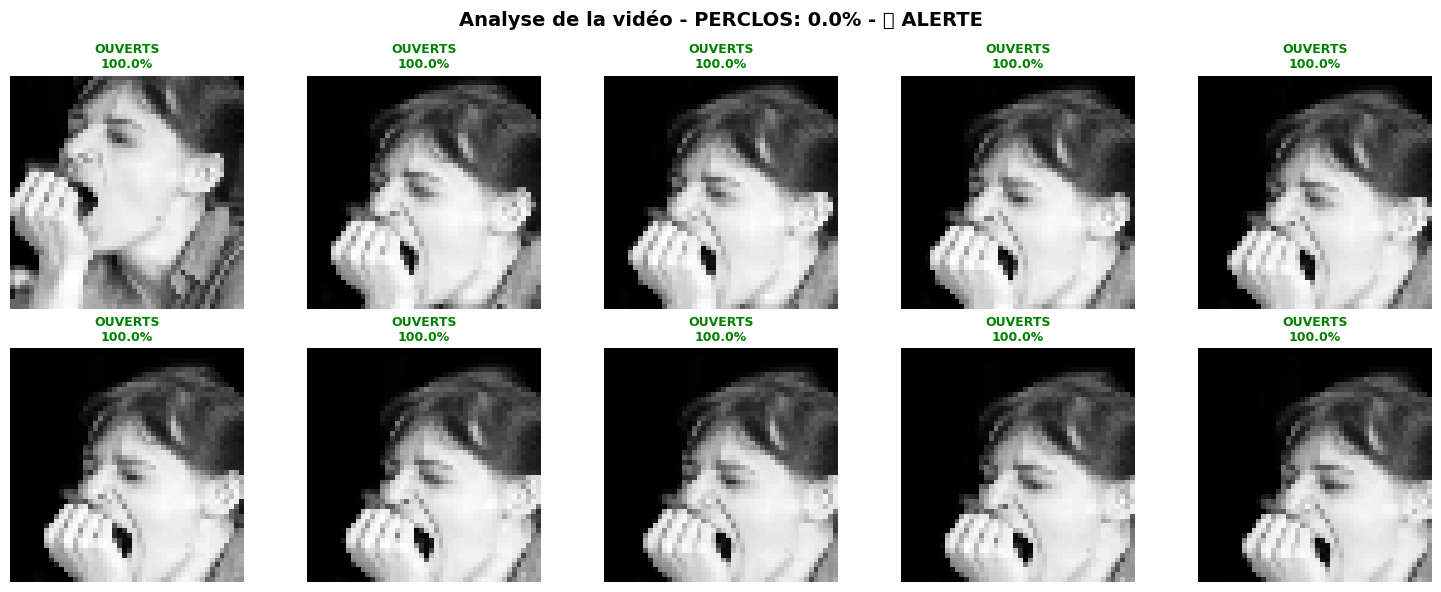

/tmp/ipython-input-275354796.py:233: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


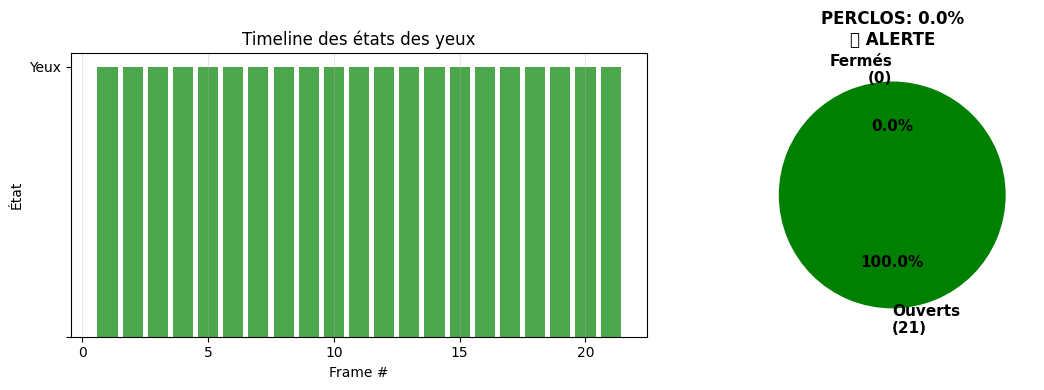


💾 Résultats détaillés sauvegardés: /content/drive/MyDrive/single_video_results.csv
💾 Résumé sauvegardé: /content/drive/MyDrive/single_video_summary.csv

🎉 Test terminé!


In [ ]:
# ========================================
# TEST PERCLOS - UNE SEULE VIDÉO (10 IMAGES)
# ========================================

import torch
import cv2
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Configuration
SAVE_DIR = "/content/"
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"🔧 Device: {device}")

# ========================================
# 1. CHARGER LE MODÈLE
# ========================================

print("\n📂 Chargement du modèle...")

seg_model = UNetSegmentation()
complete_model = CompleteFatigueDetectionModel(seg_model, freeze_seg=False)

checkpoint_path = f"{SAVE_DIR}/fatigue_model_LATEST.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)
complete_model.load_state_dict(checkpoint['model_state_dict'])
complete_model = complete_model.to(device)
complete_model.eval()

print(f"✅ Modèle chargé!")

# ========================================
# 2. FONCTION DE PRÉDICTION
# ========================================

def predict_single_image(image_path, model, device, img_size=(64, 64)):
    """Prédit le statut d'une image."""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"⚠️  Erreur: {image_path}")
        return None, None

    img = cv2.resize(img, img_size)
    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, axis=0)
    img = np.expand_dims(img, axis=0)

    img_tensor = torch.tensor(img, dtype=torch.float32).to(device)

    with torch.no_grad():
        outputs = model(img_tensor)
        probs = torch.softmax(outputs, dim=1)
        pred = torch.argmax(probs, dim=1).item()
        confidence = probs[0][pred].item()

    return pred, confidence

# ========================================
# 3. TEST SUR UNE VIDÉO (10 IMAGES)
# ========================================

def test_single_video(test_dir, model, device, perclos_threshold=0.3):
    """
    Test sur une vidéo unique (plusieurs images du même conducteur).

    Args:
        test_dir: Dossier avec les 10 images
        model: Modèle chargé
        device: 'cuda' ou 'cpu'
        perclos_threshold: Seuil pour détecter la fatigue (0.3 = 30%)
    """

    print("\n" + "="*70)
    print("🎥 TEST PERCLOS SUR UNE VIDÉO")
    print("="*70)

    # Lister toutes les images
    image_files = sorted([f for f in os.listdir(test_dir)
                         if f.endswith(('.jpg', '.png', '.jpeg'))])

    if len(image_files) == 0:
        print("❌ Aucune image trouvée!")
        return

    print(f"\n📁 Dossier: {test_dir}")
    print(f"📸 Nombre d'images: {len(image_files)}")

    # ========================================
    # Prédiction sur chaque image
    # ========================================

    predictions = []
    drowsy_count = 0
    non_drowsy_count = 0

    print(f"\n⏳ Prédiction en cours...\n")
    print(f"{'Image':<30} {'Prédiction':<15} {'Confiance':<10}")
    print("-" * 70)

    for img_file in image_files:
        img_path = os.path.join(test_dir, img_file)
        pred, conf = predict_single_image(img_path, model, device)

        if pred is not None:
            status = "😴 FERMÉS" if pred == 1 else "👁️  OUVERTS"
            predictions.append({
                'image': img_file,
                'prediction': pred,
                'status': status,
                'confidence': conf
            })

            if pred == 1:
                drowsy_count += 1
            else:
                non_drowsy_count += 1

            # Affichage avec couleur
            emoji = "😴" if pred == 1 else "👁️"
            print(f"{emoji} {img_file:<27} {status:<15} {conf*100:>6.2f}%")

    # ========================================
    # Calcul du PERCLOS
    # ========================================

    total_frames = len(predictions)
    perclos = drowsy_count / total_frames
    perclos_percent = perclos * 100
    is_fatigued = perclos > perclos_threshold

    # ========================================
    # Affichage des résultats
    # ========================================

    print("\n" + "="*70)
    print("📊 RÉSULTATS")
    print("="*70)

    print(f"\n🎥 Analyse de la vidéo:")
    print(f"  📸 Total de frames: {total_frames}")
    print(f"  👁️  Yeux OUVERTS: {non_drowsy_count} frames ({non_drowsy_count/total_frames*100:.1f}%)")
    print(f"  😴 Yeux FERMÉS: {drowsy_count} frames ({drowsy_count/total_frames*100:.1f}%)")

    print(f"\n📈 PERCLOS: {perclos_percent:.2f}%")
    print(f"🎯 Seuil de fatigue: {perclos_threshold*100:.0f}%")

    print("\n" + "="*70)

    if is_fatigued:
        print("🚨 RÉSULTAT: CONDUCTEUR FATIGUÉ ⚠️")
        print("   ⚠️  Attention recommandée!")
    else:
        print("✅ RÉSULTAT: CONDUCTEUR ALERTE 👍")
        print("   ✓ État normal détecté")

    print("="*70)

    # ========================================
    # Visualisation
    # ========================================

    # Créer une grille avec les 10 images
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle(f"Analyse de la vidéo - PERCLOS: {perclos_percent:.1f}% - " +
                 ("🚨 FATIGUÉ" if is_fatigued else "✅ ALERTE"),
                 fontsize=14, fontweight='bold')

    axes = axes.flatten()

    for idx, pred_info in enumerate(predictions[:10]):  # Max 10 images
        img_path = os.path.join(test_dir, pred_info['image'])
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        ax = axes[idx]
        ax.imshow(img, cmap='gray')

        # Couleur du cadre selon la prédiction
        color = 'red' if pred_info['prediction'] == 1 else 'green'
        for spine in ax.spines.values():
            spine.set_edgecolor(color)
            spine.set_linewidth(3)

        # Titre
        status_text = "FERMÉS" if pred_info['prediction'] == 1 else "OUVERTS"
        ax.set_title(f"{status_text}\n{pred_info['confidence']*100:.1f}%",
                     color=color, fontweight='bold', fontsize=9)
        ax.axis('off')

    # Cacher les axes inutilisés si moins de 10 images
    for idx in range(len(predictions), 10):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

    # ========================================
    # Graphique PERCLOS
    # ========================================

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Graphique 1: Timeline des prédictions
    ax1 = axes[0]
    frame_numbers = list(range(1, len(predictions) + 1))
    pred_values = [p['prediction'] for p in predictions]
    colors_timeline = ['red' if p == 1 else 'green' for p in pred_values]

    ax1.bar(frame_numbers, [1]*len(predictions), color=colors_timeline, alpha=0.7)
    ax1.set_xlabel('Frame #')
    ax1.set_ylabel('État')
    ax1.set_title('Timeline des états des yeux')
    ax1.set_yticks([0, 1])
    ax1.set_yticklabels(['', 'Yeux'])
    ax1.grid(axis='x', alpha=0.3)

    # Graphique 2: Camembert
    ax2 = axes[1]
    sizes = [non_drowsy_count, drowsy_count]
    labels = [f'Ouverts\n({non_drowsy_count})', f'Fermés\n({drowsy_count})']
    colors_pie = ['green', 'red']
    explode = (0, 0.1) if is_fatigued else (0, 0)

    ax2.pie(sizes, explode=explode, labels=labels, colors=colors_pie,
            autopct='%1.1f%%', startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
    ax2.set_title(f'PERCLOS: {perclos_percent:.1f}%\n' +
                  ('🚨 FATIGUÉ' if is_fatigued else '✅ ALERTE'),
                  fontweight='bold')

    plt.tight_layout()
    plt.show()

    # ========================================
    # Sauvegarder les résultats
    # ========================================

    results_df = pd.DataFrame(predictions)
    output_csv = "/content/drive/MyDrive/single_video_results.csv"
    results_df.to_csv(output_csv, index=False)
    print(f"\n💾 Résultats détaillés sauvegardés: {output_csv}")

    # Résumé
    summary = {
        'total_frames': total_frames,
        'drowsy_frames': drowsy_count,
        'non_drowsy_frames': non_drowsy_count,
        'PERCLOS_%': perclos_percent,
        'is_fatigued': is_fatigued,
        'status': '🚨 FATIGUÉ' if is_fatigued else '✅ ALERTE'
    }

    summary_df = pd.DataFrame([summary])
    summary_csv = "/content/drive/MyDrive/single_video_summary.csv"
    summary_df.to_csv(summary_csv, index=False)
    print(f"💾 Résumé sauvegardé: {summary_csv}")

    return predictions, summary

# ========================================
# 6. LANCER LE TEST
# ========================================

# Remplace par le chemin vers ton dossier avec les 10 images
TEST_DIR = "/content/test"

# Lancer le test
predictions, summary = test_single_video(TEST_DIR, complete_model, device, perclos_threshold=0.3)

print("\n🎉 Test terminé!")

Manque de généralisation sur des données de contexte différent